# CSE-CIC-IDS 2017

In [3]:
model_id = "dnn4-adasyn"

In [4]:
import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import glob, time, os

import keras

In [5]:
NOTEBOOK_PATH = "C:/Users/Xetrov/Desktop/SciFair20/Code/"

In [6]:
x_scaled = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_scaled_powertransform.csv")

In [7]:
y_df_enc = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_grouped_1henc.csv")

# Split data into train and test

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_valtest, y_train, y_valtest = train_test_split(x_scaled, y_df_enc, test_size = 0.4, random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, random_state = 42)

del x_valtest 
del y_valtest

In [12]:
y_train.sum(axis=0)

BENIGN          1364100
Botnet             1185
Brute Force        8273
DoS/DDoS         228292
Infiltration         24
PortScan          95267
Web Attack         1304
dtype: int64

In [13]:
y_val.sum(axis=0)

BENIGN          454207
Botnet             397
Brute Force       2810
DoS/DDoS         76510
Infiltration         7
PortScan         31787
Web Attack         431
dtype: int64

In [14]:
y_test.sum(axis=0)

BENIGN          454790
Botnet             384
Brute Force       2752
DoS/DDoS         75897
Infiltration         5
PortScan         31876
Web Attack         445
dtype: int64

# Oversampling


In [15]:
from imblearn.over_sampling import ADASYN

In [17]:
ada = ADASYN(random_state=42, n_jobs=-1)

In [ ]:
x_train_res, y_train_res = ada.fit_resample(x_train, y_train.to_numpy().argmax(axis=1))

In [31]:
np.savetxt(NOTEBOOK_PATH + "IDS2017/x_adasyn.csv", x_train_res, delimiter=",")

In [32]:
np.savetxt(NOTEBOOK_PATH + "IDS2017/y_adasyn.csv", y_train_res, delimiter=",")

In [ ]:
y_train_res2 = pd.get_dummies(y_train_res)

# Train model

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, Dropout, InputLayer
from keras.optimizers import SGD, Adam

In [ ]:
def addDenseBlock(model, units, **params):
    model.add(Dense(units=units, activation=params['hidden_activation'], input_dim=x_train.shape[1]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))

def createModel(**in_params):
    """
    Supported parameters:
    batch_normalization - True or False
    dropout_rate - 0 to 1
    num_units - integer
    learning_rate - float
    activation_function - string
    """
    
    model = Sequential()

    # Set default values
    params = {
        'batch_normalization': False,
        'dropout_rate': 0,
        'num_layers': 6,
        'num_units': 128,
        'learning_rate': 0.001,
        'hidden_activation': 'relu',
        'final_activation': 'softmax'
    }
    
    # Replace defaults with specified parameters
    for param in in_params:
        params[param] = in_params[param]    
    
    # InputLayer causes serialization issues
#     model.add( InputLayer(input_shape = (x_train.shape[1],) ) )
    
#     for i in range(params['num_layers']):
#         addDenseBlock(model, params['num_units'], **params)

    addDenseBlock(model, 128, **params)
    addDenseBlock(model, 128, **params)
    addDenseBlock(model, 256, **params)
    addDenseBlock(model, 256, **params)
    addDenseBlock(model, 128, **params)
    addDenseBlock(model, 128, **params)

    model.add(Dense(units=y_train.shape[1], activation=params['final_activation']))

    # optim = SGD(lr=0.001, nesterov=True)
    optim = Adam(lr=params['learning_rate'])

    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
#     print(params)
    
    return model

### Callbacks

In [ ]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

def timestamp():
    return time.strftime("%m-%d-%Y, %I%M%p")

csv_callback = CSVLogger(NOTEBOOK_PATH + 'Loss Logs/%s (%s)' % (model_id, timestamp()), append=True)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5)

### Model Saving

In [ ]:
savedir = NOTEBOOK_PATH + "Models/%s/" % model_id
if not os.path.exists(savedir):
    os.makedirs(savedir)
    print("Created " + savedir)
else:
    print("Using " + savedir)

Ensure a GPU is available

In [ ]:
import keras.backend as K

K.tensorflow_backend._get_available_gpus()

### Training

In [ ]:
import itertools

trainEpochs = 100

parameters = {'batch_size': 250, 'batch_normalization':True,'dropout_rate':0}

In [23]:
%%time
print(model_id)
model = createModel(**parameters)
model.summary()
model_checkpoint = ModelCheckpoint(NOTEBOOK_PATH + "Models/%s/dnn({epoch}).h5" % (model_id), monitor='val_loss')
model.fit(x_train_res, y_train, validation_data=(x_val, y_val), 
          batch_size=parameters['batch_size'], 
          epochs=trainEpochs, 
          verbose=2, 
          callbacks=[csv_callback, model_checkpoint]
         )

dnn2-classweights
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               8832      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               657

# Graph the losses

In [24]:
def most_recent_file(pattern):
    return max(glob.iglob(pattern, recursive=True), key=os.path.getctime)

logpath = most_recent_file(NOTEBOOK_PATH + "Loss Logs/%s**" % model_id)
log_df = pd.read_csv(logpath)
log_df['epoch'] += 1

print(logpath)

C:/Users/Xetrov/Desktop/SciFair20/Code/Loss Logs\dnn2-classweights (10-13-2019, 0527PM)


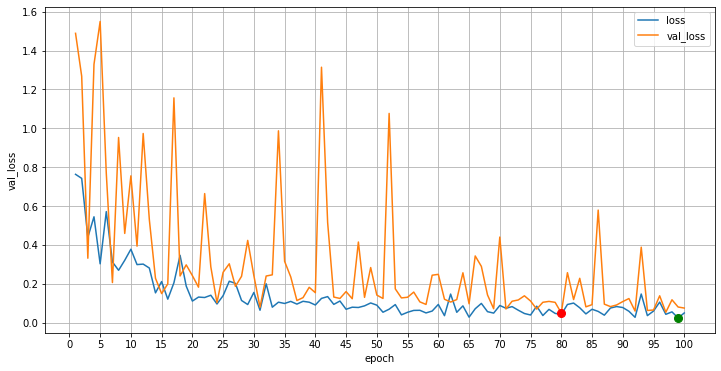

In [26]:
plot_df = log_df[:]

metric = 'loss'

plt.figure(figsize=(12,6))
sns.lineplot(x='epoch', y=metric, data=plot_df, label=metric)
sns.lineplot(x='epoch', y='val_'+metric, data=plot_df, label='val_'+metric)
plt.legend()

minEpoch = plot_df.loc[plot_df.idxmin()[metric]]
plt.plot((minEpoch['epoch']), (minEpoch[metric]), 'go', markersize=8)
minEpoch = plot_df.loc[plot_df.idxmin()['val_'+metric]]
plt.plot((minEpoch['epoch']), (minEpoch['val_'+metric]), 'ro', markersize=8)

plt.xticks(list(range(0, plot_df['epoch'].max()+1, 5)))
# plt.yticks(list(np.arange(0.0,0.4,0.05)))

plt.grid(True)

# View confusion matrix

In [27]:
print("Loading...")
model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/dnn(80).h5" % model_id)
print("Predicting...")
pred = model.predict(x_val)

print("Plotting...")
pred_index = list(pred.argmax(1))
y_index = list(np.argmax(y_val.to_numpy(), axis=1))

atktypes = sorted(y_val.columns)
pred_series = pd.Series(pred_index, name="Pred").replace(dict(enumerate(atktypes)))
y_series = pd.Series(y_index, name="Actual").replace(dict(enumerate(atktypes)))

matrix = pd.crosstab(pred_series, y_series, margins=True)
print("Done!")
matrix

Loading...
Predicting...
Plotting...
Done!


Actual,BENIGN,Botnet,Brute Force,DoS/DDoS,Infiltration,PortScan,Web Attack,All
Pred,,,,,,,,
BENIGN,446502,6,0,23,0,2,1,446534
Botnet,5044,391,0,0,0,0,0,5435
Brute Force,495,0,2810,0,0,0,0,3305
DoS/DDoS,898,0,0,76444,0,13,0,77355
Infiltration,454,0,0,0,7,0,0,461
PortScan,208,0,0,1,0,31769,0,31978
Web Attack,606,0,0,42,0,3,430,1081
All,454207,397,2810,76510,7,31787,431,566149


# F1 Score

In [28]:
from sklearn.metrics import f1_score

In [29]:
pred = model.predict(x_test, batch_size=256).argmax(axis=1)
pred_f1 = np.zeros((len(x_test), y_test.shape[1]))
for j in range(len(pred)):
    pred_f1[j,pred[j]] = 1
f1_micro = f1_score(y_test, pred_f1.astype('uint8'), average='micro')
f1_macro = f1_score(y_test, pred_f1.astype('uint8'), average='macro')
print("Micro:", f1_micro)
print("Macro:", f1_macro)

Micro: 0.9862862956571503
Macro: 0.6569235867310287


In [34]:
pred_index = pred
y_index = list(np.argmax(y_test.to_numpy(), axis=1))

atktypes = sorted(y_test.columns)
pred_series = pd.Series(pred_index, name="Pred").replace(dict(enumerate(atktypes)))
y_series = pd.Series(y_index, name="Actual").replace(dict(enumerate(atktypes)))

matrix = pd.crosstab(pred_series, y_series, margins=True)
print("Done!")
matrix.to_csv(NOTEBOOK_PATH + "Confusion Matrices/%s.csv" % model_id)
matrix

Done!


Actual,BENIGN,Botnet,Brute Force,DoS/DDoS,Infiltration,PortScan,Web Attack,All
Pred,,,,,,,,
BENIGN,447118,1,2,19,2,3,0,447145
Botnet,4974,383,0,0,0,0,0,5357
Brute Force,512,0,2749,0,0,0,0,3261
DoS/DDoS,871,0,0,75826,0,9,2,76708
Infiltration,444,0,0,1,3,0,0,448
PortScan,218,0,0,0,0,31863,0,32081
Web Attack,653,0,1,51,0,1,443,1149
All,454790,384,2752,75897,5,31876,445,566149


# Log results

In [45]:
model_log = open(NOTEBOOK_PATH + "model_log.txt", "a")

model_log.write("\n" + model_id)
model_log.write("\n\tF1 Micro: " + str(f1_micro))
model_log.write("\n\tF1 Macro: " + str(f1_macro))

model_log.close()